In [1]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.norm as norm
from autograd.scipy.special import gammaln, psi
from autograd import grad
from autograd.misc.optimizers import adam
from sklearn.metrics import mean_squared_error

import pandas as pd
from sklearn.model_selection import train_test_split as cv 
from sklearn.datasets import load_boston
from autograd.numpy.linalg import cholesky

ModuleNotFoundError: No module named 'autograd'

In [ ]:
%%capture
%run read_data.ipynb

Data size is (455, 13)
Target size is (455, 1)
Optimizing variational parameters...
Iteration: 0 lower bound: -8.59698001772399 test rmse: 2.787560445973997


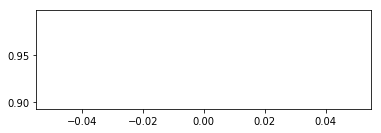

Iteration: 500 lower bound: -9.880314985605413 test rmse: 2.869180297154159


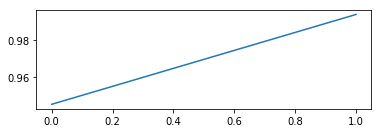

Iteration: 1000 lower bound: -9.055275938379307 test rmse: 2.903793128153844


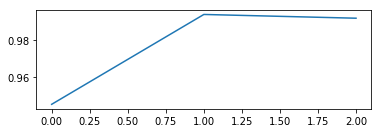

Iteration: 1500 lower bound: -14.190532738092461 test rmse: 2.807313239747717


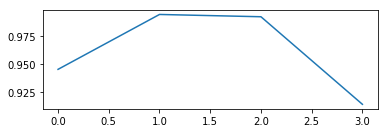

Iteration: 2000 lower bound: -9.74380493366224 test rmse: 2.8017126789248987


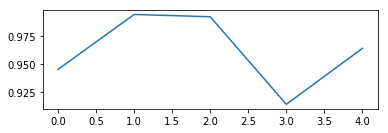

Iteration: 2500 lower bound: -10.108556698442808 test rmse: 2.7850398560104135


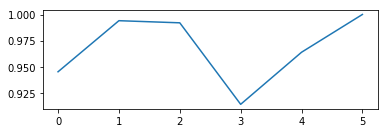

Iteration: 3000 lower bound: -10.5295702427809 test rmse: 2.8095684800196157


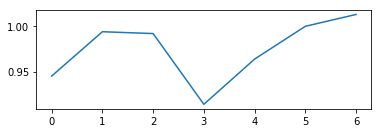

Iteration: 3500 lower bound: -9.98446208690714 test rmse: 2.7184261585240073


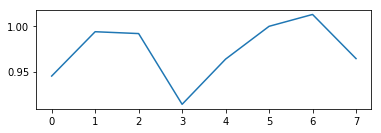

Iteration: 4000 lower bound: -11.198687336558056 test rmse: 2.836572675444214


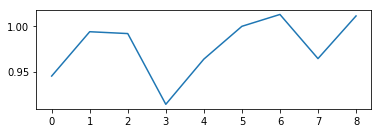

Iteration: 4500 lower bound: -10.614424507121262 test rmse: 2.812048539846507


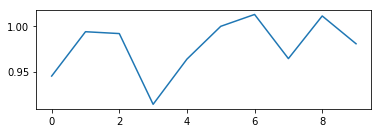

Iteration: 5000 lower bound: -14.271358016898647 test rmse: 2.695560658211796


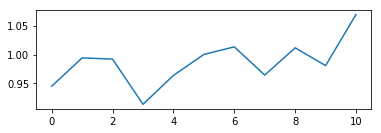

Iteration: 5500 lower bound: -10.485513714312281 test rmse: 2.834075997026912


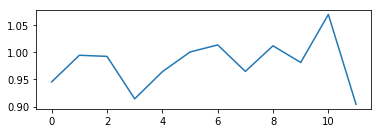

Iteration: 6000 lower bound: -9.816068818649061 test rmse: 2.7739133283278417


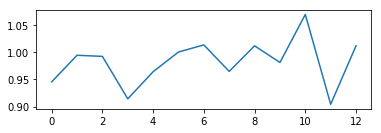

Iteration: 6500 lower bound: -14.62283136388606 test rmse: 2.761226739435001


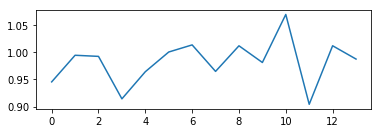

Iteration: 7000 lower bound: -12.077068073155734 test rmse: 2.686348136522853


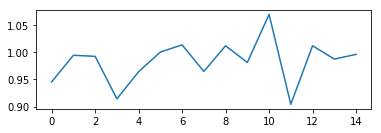

Iteration: 7500 lower bound: -8.851426979337877 test rmse: 2.7627420392520317


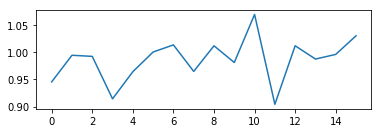

Iteration: 8000 lower bound: -8.350616984567118 test rmse: 2.7880323711264405


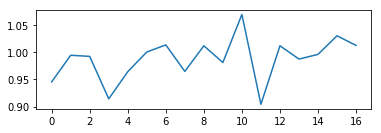

Iteration: 8500 lower bound: -14.561006426902287 test rmse: 2.8995525819270274


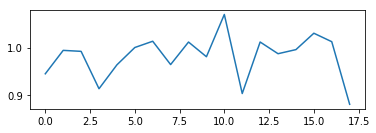

Iteration: 9000 lower bound: -11.48807837148102 test rmse: 2.8617288695764116


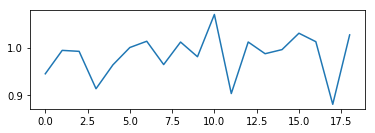

Iteration: 9500 lower bound: -12.054289500203073 test rmse: 2.8538351102455155


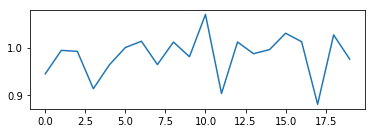

Iteration: 10000 lower bound: -9.38293021762081 test rmse: 2.879991622877793


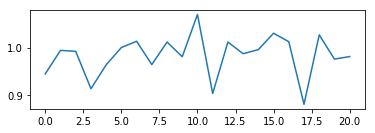

Iteration: 10500 lower bound: -11.400970341044061 test rmse: 2.802481681124257


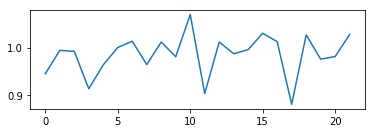

Iteration: 11000 lower bound: -9.919904737167343 test rmse: 2.8131236594536757


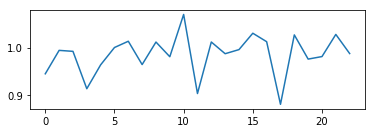

Iteration: 11500 lower bound: -11.026777949760772 test rmse: 2.882446898677038


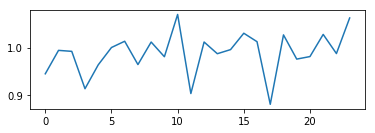

Iteration: 12000 lower bound: -15.480659927538351 test rmse: 2.8113484153303214


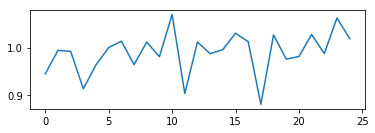

Iteration: 12500 lower bound: -11.000998068528 test rmse: 2.672917505972541


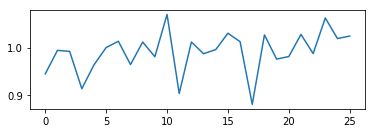

Iteration: 13000 lower bound: -12.34620046721585 test rmse: 2.7283110755348026


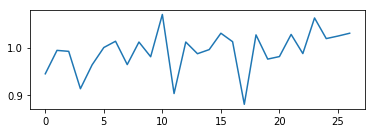

Iteration: 13500 lower bound: -9.982431816950212 test rmse: 2.7401162177394744


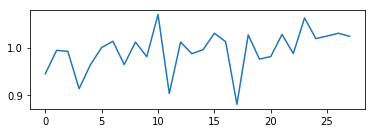

Iteration: 14000 lower bound: -9.698995127835756 test rmse: 2.76671196464922


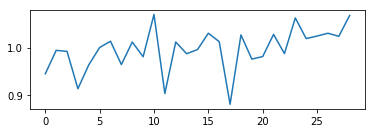

Iteration: 14500 lower bound: -8.700341146504684 test rmse: 2.7426520392121603


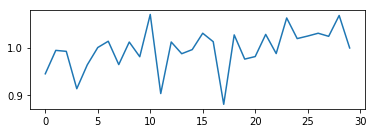

Iteration: 15000 lower bound: -7.981689354862581 test rmse: 2.732275220125244


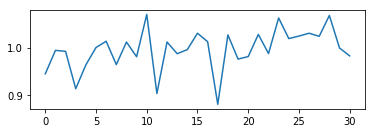

Iteration: 15500 lower bound: -14.065831308257117 test rmse: 2.909772692783696


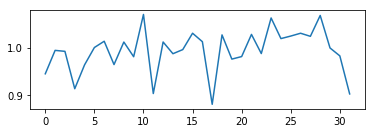

Iteration: 16000 lower bound: -10.669861598706007 test rmse: 2.968789334382151


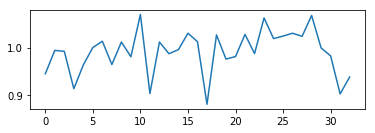

Iteration: 16500 lower bound: -9.339574518032656 test rmse: 2.9236453396376016


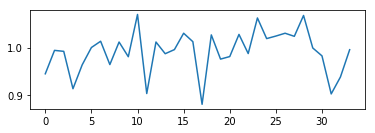

Iteration: 17000 lower bound: -9.938003174187704 test rmse: 2.870338941747425


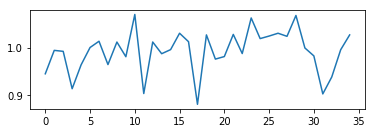

Iteration: 17500 lower bound: -9.220188538040972 test rmse: 2.8827408652237243


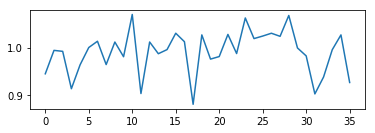

Iteration: 18000 lower bound: -10.02908960547448 test rmse: 2.8478204917570333


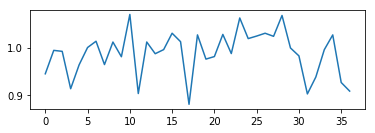

Iteration: 18500 lower bound: -9.365840909274525 test rmse: 2.806195122835732


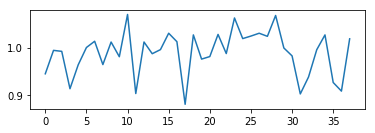

Iteration: 19000 lower bound: -17.12652198594036 test rmse: 2.6537247425327997


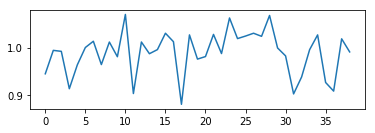

Iteration: 19500 lower bound: -10.49230394447455 test rmse: 2.6882823405158573


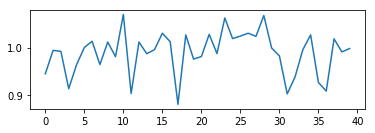

Iteration: 20000 lower bound: -14.839075862671447 test rmse: 2.7607730187839103


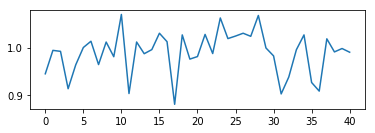

Iteration: 20500 lower bound: -10.460713626942995 test rmse: 2.703936144732955


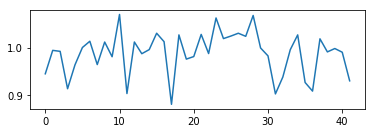

In [ ]:
def black_box_variational_inference(logprob, num_weights):
    
    def unpack_params(params):
        
        mean, log_u, log_v, t_mu, t_log_std, rest = params[:num_weights], params[num_weights:n2],\
        params[n2:n3], params[n3:n4], params[n4:n5], params[n5:]
        
        tau_mu, tau_log_std, win_u_mu, win_u_log_std, win_v_mu, win_v_log_std,\
        wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std = rest
    
        return mean, log_u, log_v, t_mu, t_log_std, tau_mu, tau_log_std, win_u_mu, win_u_log_std, win_v_mu, win_v_log_std, wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std
    
    def variational_objective(params, t):
        
        idx = batch_indices(t)
        
        mean, log_u, log_v, t_mu, t_log_std, tau_mu, tau_log_std, win_u_mu, win_u_log_std, win_v_mu, win_v_log_std, wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std  = unpack_params(params)
        
        tau_std, t_std, win_u_std,win_v_std,wout_u_std,wout_v_std = np.exp(tau_log_std), np.exp(t_log_std),\
        np.exp(win_u_log_std), np.exp(win_v_log_std), np.exp(wout_u_log_std), np.exp(wout_v_log_std)
        
        E_sigma,E_t,E_win_u,E_win_v,E_wout_u,E_wout_v = ln_mean(tau_std,tau_mu),ln_mean(t_std,t_mu),\
        ln_mean(win_u_std,win_u_mu),ln_mean(win_v_std,win_v_mu),ln_mean(wout_u_std,wout_u_mu),\
        ln_mean(wout_v_std,wout_v_mu)
        
        E_win_u_inv,E_win_v_inv,E_wout_u_inv,E_wout_v_inv = ln_mean_inv(win_u_std,win_u_mu),ln_mean_inv(win_v_std,win_v_mu),\
        ln_mean_inv(wout_u_std,wout_u_mu),ln_mean_inv(wout_v_std,wout_v_mu)
        
        E_u_inv = np.hstack((E_win_u_inv, E_wout_u_inv))
        E_v_inv = np.hstack((E_win_v_inv, E_wout_v_inv))
        
        u_mu = np.hstack((win_u_mu, wout_u_mu))
        v_mu = np.hstack((win_v_mu, wout_v_mu))
        
        lower_bound =  logprob(mean, tau_mu, E_sigma, np.exp(2 * log_u), np.exp(2 * log_v), t_mu, t_std, inputs.iloc[idx,:], targets[idx], t) + \
        1 / num_batches * (matrix_gaussian_wholesale(mean, log_u, log_v, t_mu, E_t,E_u_inv, E_v_inv, u_mu, v_mu) + \
        Ex_lognormal(E_sigma, tau_mu, sigma_a, sigma_b) + log_normal_entropy(tau_log_std,tau_mu) + \
        Ex_lognormal(E_t, t_mu, t_a, t_b) + log_normal_entropy(t_log_std,t_mu)+ \
        Ex_lognormal(E_win_u,win_u_mu, win_u_prior_a, win_u_prior_b) + log_normal_entropy(win_u_log_std,win_u_mu) + \
        Ex_lognormal(E_win_v,win_v_mu, win_v_prior_a, win_v_prior_b) + log_normal_entropy(win_v_log_std,win_v_mu) + \
        Ex_lognormal(E_wout_u,wout_u_mu, wout_u_prior_a, wout_u_prior_b) + log_normal_entropy(wout_u_log_std,wout_u_mu) + \
        Ex_lognormal(E_wout_v,wout_v_mu, wout_v_prior_a, wout_v_prior_b) + log_normal_entropy(wout_v_log_std,wout_v_mu))                 
                           
        return - lower_bound
    
    gradient = grad(variational_objective)
    
    return variational_objective, gradient, unpack_params

def make_nn_funs(layer_sizes):

    shapes = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    num_weights = np.sum((m + 1) * n for m, n in shapes)

    def unpack_layers(weights,u,v):
        for m, n in shapes:
            yield weights[:m * n + n].reshape((m + 1, n)),\
                  np.diag(np.hstack((factor ** 2,u[:m]))),\
                  np.diag(np.hstack((factor ** 2,v[:(n-1)]))),\
                  m,\
                  n
            weights = weights[m * n + n:]
            u = u[m:]
            v = v[(n-1):]

    def predictions(weights,u,v,t_mu,t_std,inputs):
        for count, (W,u,v,m,n) in enumerate(unpack_layers(weights,u,v)): 
            sig2 = np.exp(npr.randn(1) * t_std[count] + t_mu[count])
            #sig2 = np.exp(0.25 * t_std[count] ** 2 + 0.5 * t_mu[count])
            inputs = np.hstack((inputs/np.sqrt(inputs.shape[1]),np.ones((inputs.shape[0],1))))
            W_mat = np.dot(inputs, W)
            u_mat = np.dot(np.dot(inputs, u),inputs.T)
            u_sqrt = cholesky(u_mat + np.diag(juju * np.ones(u_mat.shape[0])))
            #u_sqrt = cholesky(u_mat)
            v_sqrt = cholesky(sig2 * v)            
            stdn = npr.normal(size = W_mat.shape)
            outputs = W_mat + np.dot(u_sqrt,np.dot(stdn,v_sqrt.T))    
               
#             stdn = npr.normal(size = W_mat.shape)
# #             kobe = np.kron(v,u_mat + np.diag(juju * np.ones(u_mat.shape[0]))) 
#             kobe = np.kron(v,u_mat) 
#             scale = cholesky(kobe)
#             outputs = (np.dot(scale,stdn.ravel()) + W_mat.ravel(order='F')).reshape(W_mat.shape,order='F')
            inputs = outputs * (outputs > 0)
        
        return outputs
    
    def predictions_targets(weights,u,v,t_mu,t_std,inputs):
        for count, (W,u,v,m,n) in enumerate(unpack_layers(weights,u,v)): 
            inputs = np.hstack((inputs/np.sqrt(inputs.shape[1]),np.ones((inputs.shape[0],1))))
            outputs = np.dot(inputs,W)
            inputs = outputs * (outputs > 0)
        return outputs
    
    def logprob(weights, Elog_sigma, E_sigma,u,v,t_mu,t_std, inputs,targets,t):
        
        preds = predictions(weights,u,v,t_mu,t_std,inputs)
        log_lik = np.sum(- 0.5 * np.log(pi2) + 0.5 * Elog_sigma - (0.5 * (targets - preds) ** 2 * E_sigma))
        return log_lik 

    return shapes, num_weights, predictions, logprob, predictions_targets

def matrix_gaussian_wholesale(mean,log_u,log_v,t_mu, E_t, E_u_inv, E_v_inv, u_mu, v_mu):
    
    entropy_master = ex_mg_master = 0
    for count, (m,n) in enumerate(shapes):   
        entropy =  0.5 * (n * (m + 1) + (m + 1) * (n * t_mu[count] + 2 * (np.log(factor) + np.sum(log_v[:(n-1)])) ) + 2 * n * (np.log(factor) + np.sum(log_u[:m])) )
        ex_mg = - 0.5 * ( n * (m + 1) * (u_mu[count] + v_mu[count]) + E_t[count] * E_u_inv[count] * E_v_inv[count] * (factor ** 2 + np.sum(np.exp(2 * log_u[:m])) ) * (factor ** 2 + np.sum(np.exp(2 * log_v[:(n-1)])) ) + E_u_inv[count] * E_v_inv[count] * np.sum(mean[:(m + 1) * n] ** 2))
        log_u = log_u[m:]
        log_v = log_v[(n - 1):]
        mean = mean[(m + 1) * n:]
        entropy_master = entropy_master + entropy
        ex_mg_master =  ex_mg_master + ex_mg

#     for count, (m,n) in enumerate(shapes):   
#         entropy =  0.5 * ((n-1) * m + m * ((n-1) * t_mu[count] + 2 * (np.sum(log_v[:(n-1)])) ) + 2 * (n-1) * (np.sum(log_u[:m])) )
#         ex_mg = - 0.5 * ( (n-1) * m * (u_mu[count] + v_mu[count]) + E_t[count] * E_u_inv[count] * E_v_inv[count] * (np.sum(np.exp(2 * log_u[:m])) ) * (np.sum(np.exp(2 * log_v[:(n-1)])) ) + E_u_inv[count] * E_v_inv[count] * np.sum(mean[:(m + 1) * n] ** 2))
#         log_u = log_u[m:]
#         log_v = log_v[(n - 1):]
#         mean = mean[(m + 1) * n:]
#         entropy_master = entropy_master + entropy
#         ex_mg_master =  ex_mg_master + ex_mg    
    return entropy_master + ex_mg_master

def softmax(x):
    #e_x = np.exp(x - np.max(x))
    #return e_x / e_x.sum()
    return np.log1p(np.exp(x))

def ln_mean(std,mu):
    return np.exp(0.5 * std ** 2 + mu)

def ln_mean_inv(std,mu):
    return np.exp(0.5 * std ** 2 - mu)

def init_gamma(a,b):
    return np.log(a/b)
#      return np.log(b/(a+1))
def log_normal_entropy(log_std, mu):
    return np.sum(log_std + mu + 0.5 + 0.5 * np.log(2 * np.pi))

def Ex_lognormal (E_tau, mu, a, b):
    return np.sum(a * np.log(b) - gammaln(a) + (a - 1) * mu - b * E_tau)

def inialization(shapes):
    
    rs = npr.RandomState(0)
    w = []
    
    for m, n in shapes:
        w = np.append(w,rs.randn(m * n) * np.sqrt(2 / m))
        w = np.append(w,np.zeros(n))
        #w = np.append(w,rs.randn(n)*0.01)
        
    u = -5 * np.ones(num_u)
    v = -5 * np.ones(num_v)
    
    init_tau_mu = init_gamma(sigma_a, sigma_b)
    init_tau_log_std = -5 
    t_mu = init_gamma(t_a, t_b)
    t_log_std = -5 * np.ones(num_t)
    
    init_win_u_mu = init_gamma(win_u_prior_a, win_u_prior_b)
    init_win_v_mu = init_gamma(win_v_prior_a, win_v_prior_b)
    init_wout_u_mu = init_gamma(wout_u_prior_a, wout_u_prior_b)
    init_wout_v_mu = init_gamma(wout_v_prior_a, wout_v_prior_b)
    
    init_win_u_log_std = init_win_v_log_std = init_wout_u_log_std = init_wout_v_log_std = -5
    
    init_var_params = np.concatenate([w, u, v, t_mu, t_log_std, [init_tau_mu,init_tau_log_std,\
            init_win_u_mu,init_win_u_log_std, init_win_v_mu, init_win_v_log_std, init_wout_u_mu,
            init_wout_u_log_std, init_wout_v_mu,init_wout_v_log_std]])

    return init_var_params

def plot1(mean_master,num_weights):
    mean_final = mean_master.reshape(len(mean_master) // num_weights, num_weights)
    plt.subplot(212)
    plt.plot(mean_final[-100:,0])
    plt.show()    
        
def batch_indices(t):
    idx = t % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

if __name__ == '__main__':
    
    toy = False
    init = True
    scale = True
    step = 0.005
    
    factor = 1
    
    data_state = 5
    pi2 = 2 * np.pi
    output_size = 1
    split_size = 0.1

    sigma_a = 6
    sigma_b = 6
    
    t_a = np.array([1,2])
    t_b = np.array([0.5,10])
    
    win_u_prior_a = 1
    win_u_prior_b = 0.5
    
    win_v_prior_a = 1
    win_v_prior_b = 0.5
    
    wout_u_prior_a = 1
    wout_u_prior_b = 0.5
    
    wout_v_prior_a = 1
    wout_v_prior_b = 0.5
    
    prior_a_list = np.array([win_u_prior_a,win_v_prior_a, wout_u_prior_a, wout_v_prior_a])
    prior_b_list = np.array([win_u_prior_b,win_v_prior_b, wout_u_prior_b, wout_v_prior_b])
    
    juju = 1e-8
    ## 0.03 works for toy
    u_v_posterior = t_std_master = t_mu_master = mean_master = u_master = v_master = tau_master = tau_mu_master = rmse_master = tau_std_master = []
    
    if toy == True:
        x_len = 200
        noise = 0.1
        inputs, inputs_test, targets,  targets_test, dim, train_std, train_mu = build_toy_dataset(x_len,noise,split_size, seed=1990, state=0)
        index_train = np.squeeze(np.argsort(inputs,axis=0))  
        index_test = np.squeeze(np.argsort(inputs_test,axis=0))   
    else:
        inputs, inputs_test, targets,  targets_test, dim, train_std, train_mu = build_boston_dataset(split_size,scale, state=data_state)

    sup = [dim, 50, output_size]
    shapes, num_weights, predictions, logprob, predictions_targets = \
        make_nn_funs(layer_sizes=sup)
    
    num_t = len(shapes)
    num_u = np.sum(sup[:-1])
    num_v = np.sum(sup[1:]) - num_t
    n2 = num_weights + num_u 
    n3 = n2 + num_v
    n4 = n3 + num_t
    n5 = n4 + num_t
    
    
    num_epochs = 3501
    #Make sure Matrix Gaussian has full rank to sample
    batch_size = 13
    
    if batch_size > inputs.shape[0]:
        batch_size = inputs.shape[0] 
    
    num_batches = int(np.ceil(inputs.shape[0]/ batch_size))
    max_iter = num_epochs * num_batches
    
    if init == True:
        init_var_params = np.loadtxt('init.txt')
    else:
        init_var_params = inialization(shapes)
    
    # Build variational objective.
    objective, gradient, unpack_params = \
        black_box_variational_inference(logprob, num_weights)
    print("Data size is",inputs.shape)
    print("Target size is",targets.shape)
    def callback(params, t, g):
        if t % 1000 == 0:
            np.savetxt('init.txt', params)  
        if t % 500 == 0 or t == max_iter:
            mean, log_u, log_v, t_mu, t_log_std, tau_mu, tau_log_std, win_u_mu, win_u_log_std, win_v_mu, win_v_log_std, wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std = unpack_params(params)
            u2,v2 = np.exp(2 * log_u), np.exp(2 * log_v)
            t_std = np.exp(t_log_std)
            outputs = predictions_targets(mean,u2,v2,t_mu,t_std,inputs_test)
            rmse = acc_rmse(targets_test,outputs,train_std,train_mu)
            
            print("Iteration: {} lower bound: {} test rmse: {}".format(t, -objective(params, t),rmse))
            
            global u_v_posterior,mean_master, tau_mu_master, tau_std_master, rmse_master, tau_master, u_master, v_master, t_mu_master, t_std_master
            tau_mu_master = np.append(tau_mu_master, tau_mu)
            tau_std_master = np.append(tau_std_master, np.exp(tau_log_std))
            rmse_master = np.append(rmse_master, rmse)
            tau_master = np.append(tau_master, 0.5 * np.exp(tau_log_std) ** 2 + tau_mu)
            u_master = np.append(u_master,u2)
            v_master = np.append(v_master,v2)
            mean_master = np.append(mean_master,mean)
            t_mu_master = np.append(t_mu_master, t_mu)
            t_std_master = np.append(t_std_master, t_std)
            zip_all = np.hstack((win_u_mu, win_u_log_std, win_v_mu, win_v_log_std, wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std))
            u_v_posterior = np.append(u_v_posterior,zip_all )
            plot1(u_master,num_u)
            plt.pause(1.0/60.0)
    print("Optimizing variational parameters...")
    variational_params = adam(gradient, init_var_params,
                              step_size = step, num_iters = max_iter, callback=callback)

In [ ]:
plt.plot(tau_mu_master[-50:])

In [ ]:
plt.plot(tau_std_master[-50:])

In [ ]:
plt.plot(1/np.exp(tau_master)[-100:])

In [ ]:
mean, log_u, log_v, t_mu, t_log_std, tau_mu, tau_log_std, win_u_mu, win_u_log_std, win_v_mu, win_v_log_std, wout_u_mu, wout_u_log_std, wout_v_mu, wout_v_log_std = unpack_params(variational_params)

In [ ]:
ln_mean(np.exp(win_u_log_std),win_u_mu)

In [ ]:
ln_mean(np.exp(win_v_log_std),win_v_mu)

In [ ]:
ln_mean(np.exp(wout_u_log_std),wout_u_mu)

In [ ]:
ln_mean(np.exp(wout_v_log_std),wout_v_mu)

In [ ]:
def shrink_prob(mean):
    #mean = mean[:-num_output_w]
    print(len(mean[np.abs(mean)< 0.1])/len(mean))
    print(len(mean[np.abs(mean)< 0.001])/len(mean))
    print(len(mean[np.abs(mean)< 0.00001])/len(mean))
    print(len(mean[np.abs(mean)< 0.0000001])/len(mean))
    print(len(mean[np.abs(mean)< 0.000000001])/len(mean))

shrink_prob(mean)

In [ ]:
# a = variational_params
# np.savetxt('init.txt', a)

In [ ]:
plt.plot(test_std * targets_test)
plt.plot(test_std * outputs.T,)

In [ ]:
def trace_plot(mean_master,num_weights):
    mean_final = mean_master.reshape(len(mean_master) // num_weights, num_weights)
    for i in range(mean_final.shape[1]):
        plt.subplot(212)
        plt.plot(mean_final[:,i])
        plt.show()    
        
def trace_plot_last(mean_master,num_weights):
    mean_final = mean_master.reshape(len(mean_master) // num_weights, num_weights)
    for i in range(mean_final.shape[1]):
        plt.subplot(212)
        plt.plot(mean_final[-200:,i])
        plt.show()    

In [ ]:
trace_plot(t_std_master,num_t)

In [ ]:
trace_plot(t_mu_master,num_t)

In [ ]:
trace_plot(mean_master,num_weights)

In [ ]:
trace_plot(u_master,num_u)

In [ ]:
trace_plot(v_master,num_v)

In [ ]:
trace_plot_last(v_master,num_v)

In [ ]:
trace_plot_last(u_v_posterior,8)

In [ ]:
outputs = predictions(mean,mean_bias,np.exp(log_std),np.exp(log_std_bias),inputs)
sigma = np.exp(log_b)/(np.exp(log_a)+1)
temp = norm.logpdf(targets,outputs,np.sqrt(sigma))

In [ ]:
threshold = 1e-1
a = norm.cdf(threshold,loc=mean[:-num_output_w],scale=np.exp(log_std)[:-num_output_w])-norm.cdf(-threshold,loc=mean[:-num_output_w],scale=np.exp(log_std)[:-num_output_w])
np.sum(a>0.90)/len(a)

In [ ]:
from copy import copy
def output_shrink(mean):
    index = np.where(a>0.9)[0]
    mean_shrink =copy(mean)
    mean_shrink[index] = 0
    return mean_shrink

mean_shrink = output_shrink(mean)

In [ ]:
outputs = predictions(mean_shrink, mean_bias, np.zeros(num_weights), np.zeros(num_biases), inputs_test)
rmse = acc_rmse(targets_test,outputs,train_std,train_mu)
rmse

In [ ]:
import seaborn as sb
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
wstack = mean[:np.prod(shapes[0])].reshape(shapes[0])
sb.set_context("paper", rc={"lines.linewidth": 5, "lines.markersize":10, 'axes.labelsize': 8,
   'text.fontsize': 8,
   'legend.fontsize': 15,
   'xtick.labelsize': 15,
   'ytick.labelsize': 15,
   'ylabel.fontsize':15,
   'xlabel.fontsize':15,
   'text.usetex': False,
    'axes.titlesize' : 25,
    'axes.labelsize' : 25,  })
sb.set_style("darkgrid")

plt.figure(figsize=(18,16))
axx = plt.gca()
idx = np.argsort(np.linalg.norm(wstack, axis=0))
sb.boxplot(data=wstack[:, idx], orient="h", ax=axx)
plt.show(block=True)